# Rice Disease Detection

In [81]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Bidirectional, LSTM, Reshape, Dropout, MultiHeadAttention
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

import seaborn as sb
from sklearn.metrics import confusion_matrix

## Allocate memory and environment to GPU

In [2]:
phy_devices = tf.config.experimental.list_physical_devices('GPU')
print(phy_devices)
if phy_devices:
    print("Memory allocation and computations pushed to GPU env")
    tf.config.experimental.set_memory_growth(phy_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Memory allocation and computations pushed to GPU env


## Data extraction and augmentation

In [3]:
#dataset path
dataset_dir = 'D:/Andrei/Andrei/Prog Applications/datasets'
dataset_name = '/Rice diseases exclusively'
dataset_dir = dataset_dir + dataset_name

#image details
size = (224, 224)
img_color_mode = 'rgb'
img_type = '.jpg'

In [86]:
class_names=[]
for file in os.listdir(dataset_dir):
    class_names+=[file]
print(class_names)
print(len(class_names))

['blast', 'blight', 'tungro']
3


In [105]:
N=[]
for i in range(len(class_names)):
    N+=[i]
    
normal_mapping=dict(zip(class_names,N)) 
reverse_mapping=dict(zip(N,class_names)) 

def mapper(value):
    return reverse_mapping[value]

In [117]:
# Append images to dataset var converted to 2d arrays
dataset = []
count=0
for name in class_names:
    path=os.path.join(dataset_dir,name)
    t=0
    for im in os.listdir(path):
        if im[-4:]==img_type:
            image=load_img(
                os.path.join(path,im),
                grayscale=False, 
                color_mode=img_color_mode, 
                target_size=size
            )
            image=img_to_array(image)
            image=image/255.0 #normalize
            dataset.append([image,count])
    count=count+1

In [118]:
data,labels0=zip(*dataset)

In [119]:
labels1=to_categorical(labels0)
data=np.array(data)
labels=np.array(labels1)

## Data Splitting

In [228]:
# 60% training, 20% testing, 20% validation data split
dataset_size = len(dataset)
train_split_ratio = 0.80
test_split_ratio = 0.20

# getting the ratio of validation set from train set by using this formula
# this equates to somewhere close or near the 20% if extracted from the combined dataset
valid_split_ratio = (dataset_size * test_split_ratio) / (dataset_size * train_split_ratio) 

In [230]:
# split training/validation dataset from testing dataset [80:20]
trainvalidx, testx, trainvalidy, testy = train_test_split(
    data, 
    labels, 
    test_size=test_split_ratio, 
    random_state=27
)

In [232]:
# split training and validation dataset [60:20]
trainx, validx, trainy, validy = train_test_split(
    trainvalidx, 
    trainvalidy, 
    test_size=valid_split_ratio, 
    random_state=27
)

In [246]:
print(f"Training data shape: {trainx.shape}")
print(f"Validation data shape: {validx.shape}")
print(f"Testing data shape: {testx.shape}")
print(f"Training images {round((train_split_ratio - (train_split_ratio * valid_split_ratio))* 100)}% : {trainx.shape[0]}")
print(f"Validation images {round(train_split_ratio*valid_split_ratio* 100) }% : {validx.shape[0]}")
print(f"Testing images {round(test_split_ratio * 100)}% : {testx.shape[0]}")
print("=" *30)
print(f"Total Images: {trainx.shape[0]+validx.shape[0]+testx.shape[0]}")
print(f"Classifications: {len(class_names)}, {class_names}")

Training data shape: (144, 224, 224, 3)
Validation data shape: (48, 224, 224, 3)
Testing data shape: (48, 224, 224, 3)
Training images 60% : 144
Validation images 20% : 48
Testing images 20% : 48
Total Images: 240
Classifications: 3, ['blast', 'blight', 'tungro']


## Augmentation

In [56]:
datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    fill_mode="nearest"
)

# Models

### Custom Layers

In [328]:
def ReshapeLayer(x):
    shape = x.shape
    reshape = Reshape((shape[1],shape[2]*shape[3]))(x)
    return reshape

def BiLSTMLayer(x, neurons=128):
    # Tanh Activation provides access of the LSTM to the cuDNN which provides faster computation
    return Bidirectional(LSTM(neurons, activation='tanh', recurrent_dropout=0))(x)

def AttentionLayer(x, heads = 1, dim = 1, training = False):
    return MultiHeadAttention(num_heads=heads, key_dim=dim)(x, x, training=training)

In [329]:
def DenseBilstm(attention=False):
    cnn = tf.keras.applications.DenseNet201(
        input_shape=(size[0],size[1],3),
        include_top=False,
        weights='imagenet'
    )
    cnn.trainable = False
    
    #Model Sequence
    images = cnn.input
    x = cnn.output
    if attention:
        x = AttentionLayer(x, heads = 2, dim = 1, training = True)
    x = ReshapeLayer(x)
    x = BiLSTMLayer(x, 128)
    pred = Dense(3, activation='softmax')(x)
        
    model = tf.keras.Model(inputs=images, outputs=pred)
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    
    return model

In [330]:
def MoBilstm(attention=False):
    cnn = tf.keras.applications.MobileNet(
        input_shape=(size[0],size[1],3),
        include_top=False,
        weights='imagenet'
    )
    cnn.trainable = False
    
    #Model Sequence
    images = cnn.input
    x = cnn.output
    if attention:
        x = AttentionLayer(x, heads = 2, dim = 1, training = True)
    x = ReshapeLayer(x)
    x = BiLSTMLayer(x, 128)
    pred = Dense(3, activation='softmax')(x)
    
    model = tf.keras.Model(inputs=images, outputs=pred)
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    return model

# Training without Attention

In [292]:
# set early stopping criteria
pat = 5 # this is the number of epochs with no improvment after which the training will stop
early_stopping = EarlyStopping(monitor='val_loss', patience=pat, verbose=1, baseline=None)

# to save the history of models
csv_logger = CSVLogger(f'logs/{model_label}.log', separator=",", append=True)

# define the model checkpoint callback -> this will keep on saving the model as a physical file
def ModelCheckPointCB(model_label = 'mnet_bilstm_sample1', save_best_only=True):
    return ModelCheckpoint(
        f'model_checkpoints/{model_label}.h5', 
        verbose=1, save_best_only=save_best_only
    )

In [293]:
model1 = DenseBilstm(attention = False)
model1.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_28 (ZeroPadding2 (None, 230, 230, 3)  0           input_20[0][0]                   
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_28[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
___________________________________________________________________________________________

In [294]:
# model 1, DenseBiLSTM_noAttention
model_label = "DenseBiLSTM_noAttention"
history1 = model1.fit(
        x = datagen.flow(trainx,trainy,batch_size=16),
        validation_split = valid_split_ratio,
        batch_size=32,
        epochs=50,
        callbacks=[early_stopping, ModelCheckPointCB(model_label), csv_logger],
        verbose=1,            
    )

Epoch 1/50
9/9 [==============================] - 24s 813ms/step - loss: 1.3505 - accuracy: 0.4444 - val_loss: 0.7303 - val_accuracy: 0.7917

Epoch 00001: val_loss improved from inf to 0.73032, saving model to model_checkpoints\DenseBiLSTM_noAttention.h5
Epoch 2/50
9/9 [==============================] - 2s 243ms/step - loss: 0.6594 - accuracy: 0.7917 - val_loss: 0.5965 - val_accuracy: 0.7292

Epoch 00002: val_loss improved from 0.73032 to 0.59654, saving model to model_checkpoints\DenseBiLSTM_noAttention.h5
Epoch 3/50
9/9 [==============================] - 2s 242ms/step - loss: 0.4260 - accuracy: 0.8819 - val_loss: 0.5136 - val_accuracy: 0.7917

Epoch 00003: val_loss improved from 0.59654 to 0.51364, saving model to model_checkpoints\DenseBiLSTM_noAttention.h5
Epoch 4/50
9/9 [==============================] - 2s 242ms/step - loss: 0.2902 - accuracy: 0.9167 - val_loss: 0.3418 - val_accuracy: 0.8958

Epoch 00004: val_loss improved from 0.51364 to 0.34181, saving model to model_checkpoint

In [295]:
# model 2, MoBiLSTM_noAttention
model2 = MoBilstm(attention = False)
model2.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0  

In [296]:
model_label2 = "MoBiLSTM_noAttention"
history2 = model2.fit(
        x = datagen.flow(trainx,trainy,batch_size=16),
        validation_data = ImageDataGenerator().flow(validx, validy, batch_size=16),
        batch_size=32,
        epochs=50,
        callbacks=[early_stopping, ModelCheckPointCB(model_label2), csv_logger],
        verbose=1,            
    )

Epoch 1/50
9/9 [==============================] - 11s 759ms/step - loss: 1.7057 - accuracy: 0.3889 - val_loss: 0.9027 - val_accuracy: 0.5833

Epoch 00001: val_loss improved from inf to 0.90272, saving model to model_checkpoints\MoBiLSTM_noAttention.h5
Epoch 2/50
9/9 [==============================] - 2s 209ms/step - loss: 0.8633 - accuracy: 0.6319 - val_loss: 0.7984 - val_accuracy: 0.6458

Epoch 00002: val_loss improved from 0.90272 to 0.79837, saving model to model_checkpoints\MoBiLSTM_noAttention.h5
Epoch 3/50
9/9 [==============================] - 2s 218ms/step - loss: 0.6618 - accuracy: 0.8194 - val_loss: 0.6443 - val_accuracy: 0.7500

Epoch 00003: val_loss improved from 0.79837 to 0.64431, saving model to model_checkpoints\MoBiLSTM_noAttention.h5
Epoch 4/50
9/9 [==============================] - 2s 209ms/step - loss: 0.5248 - accuracy: 0.8333 - val_loss: 0.5711 - val_accuracy: 0.7708

Epoch 00004: val_loss improved from 0.64431 to 0.57110, saving model to model_checkpoints\MoBiLST

## Data Presentation

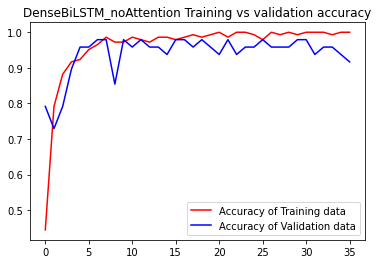

<Figure size 432x288 with 0 Axes>

In [297]:
get_acc = history1.history['accuracy']
value_acc = history1.history['val_accuracy']
get_loss = history1.history['loss']
validation_loss = history1.history['val_loss']

epochs = range(len(get_acc))
plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
plt.plot(epochs, value_acc, 'b', label='Accuracy of Validation data')
plt.title(f'{model_label} Training vs validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

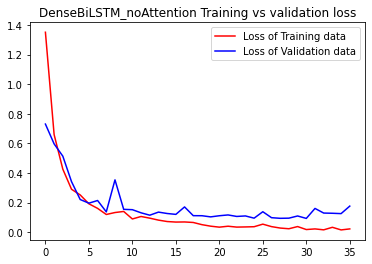

<Figure size 432x288 with 0 Axes>

In [298]:
epochs = range(len(get_loss))
plt.plot(epochs, get_loss, 'r', label='Loss of Training data')
plt.plot(epochs, validation_loss, 'b', label='Loss of Validation data')
plt.title(f'{model_label} Training vs validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

[Text(0, 0.5, 'blast'), Text(0, 1.5, 'blight'), Text(0, 2.5, 'tungro')]

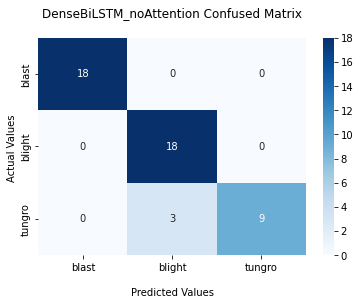

In [299]:
y_pred=model1.predict(testx)
pred=np.argmax(y_pred,axis=1)
ground = np.argmax(testy,axis=1)

conf_matrix = confusion_matrix(ground, pred)
ax = sb.heatmap(conf_matrix, annot=True, cmap='Blues')
ax.set_title(f'{model_label} Confused Matrix\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)

In [300]:
print(classification_report(ground,pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       0.86      1.00      0.92        18
           2       1.00      0.75      0.86        12

    accuracy                           0.94        48
   macro avg       0.95      0.92      0.93        48
weighted avg       0.95      0.94      0.94        48



In [302]:
model1.evaluate(x=ImageDataGenerator().flow(testx, testy, batch_size=32), verbose = 1)

2/2 [==============================] - 0s 146ms/step - loss: 0.1664 - accuracy: 0.9375


[0.16636617481708527, 0.9375]

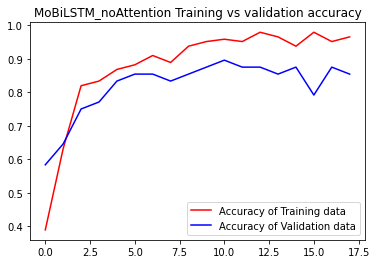

<Figure size 432x288 with 0 Axes>

In [305]:
get_acc = history2.history['accuracy']
value_acc = history2.history['val_accuracy']
get_loss = history2.history['loss']
validation_loss = history2.history['val_loss']

epochs = range(len(get_acc))
plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
plt.plot(epochs, value_acc, 'b', label='Accuracy of Validation data')
plt.title(f'{model_label2} Training vs validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

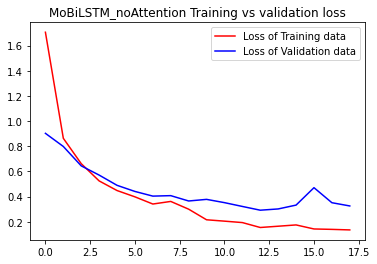

<Figure size 432x288 with 0 Axes>

In [306]:
epochs = range(len(get_loss))
plt.plot(epochs, get_loss, 'r', label='Loss of Training data')
plt.plot(epochs, validation_loss, 'b', label='Loss of Validation data')
plt.title(f'{model_label2} Training vs validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

[Text(0, 0.5, 'blast'), Text(0, 1.5, 'blight'), Text(0, 2.5, 'tungro')]

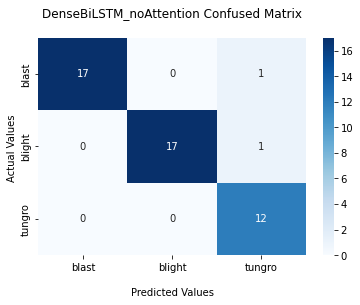

In [307]:
y_pred=model2.predict(testx)
pred=np.argmax(y_pred,axis=1)
ground = np.argmax(testy,axis=1)

conf_matrix = confusion_matrix(ground, pred)
ax = sb.heatmap(conf_matrix, annot=True, cmap='Blues')
ax.set_title(f'{model_label} Confused Matrix\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)

In [308]:
print(classification_report(ground,pred))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        18
           1       1.00      0.94      0.97        18
           2       0.86      1.00      0.92        12

    accuracy                           0.96        48
   macro avg       0.95      0.96      0.96        48
weighted avg       0.96      0.96      0.96        48



In [309]:
model2.evaluate(x=ImageDataGenerator().flow(testx, testy, batch_size=32), verbose = 1)

2/2 [==============================] - 0s 46ms/step - loss: 0.1961 - accuracy: 0.9583


[0.19610244035720825, 0.9583333134651184]

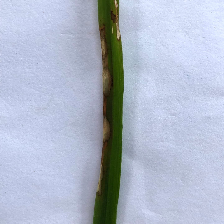

In [310]:
image = load_img(f"{dataset_dir}/blight/IMG_1034.jpg",target_size=(224,224))
image

In [311]:
image=img_to_array(image) 
image=image/255.0
prediction_image=np.array(image)
prediction_image= np.expand_dims(image, axis=0)

In [312]:
prediction=model1.predict(prediction_image)
value=np.argmax(prediction)
move_name=mapper(value)
#print(prediction)
#print(value)
print("Prediction is {}.".format(move_name))

Prediction is blight.


In [313]:
prediction=model2.predict(prediction_image)
value=np.argmax(prediction)
move_name=mapper(value)
#print(prediction)
#print(value)
print("Prediction is {}.".format(move_name))

Prediction is blight.


# Training with Attention 

In [331]:
model1 = DenseBilstm(attention = True)
model1.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_38 (ZeroPadding2 (None, 230, 230, 3)  0           input_26[0][0]                   
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_38[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
___________________________________________________________________________________________

In [332]:
# model 1, DenseBiLSTM_Attention
model_label = "DenseBiLSTM_Attention"
history1 = model1.fit(
        x = datagen.flow(trainx,trainy,batch_size=16),
        validation_data = ImageDataGenerator().flow(validx, validy, batch_size=16),
        batch_size=32,
        epochs=50,
        callbacks=[early_stopping, ModelCheckPointCB(model_label), csv_logger],
        verbose=1,            
    )

Epoch 1/50
9/9 [==============================] - 27s 878ms/step - loss: 1.1242 - accuracy: 0.4931 - val_loss: 1.2827 - val_accuracy: 0.4167

Epoch 00001: val_loss improved from inf to 1.28265, saving model to model_checkpoints\DenseBiLSTM_Attention.h5
Epoch 2/50
9/9 [==============================] - 2s 255ms/step - loss: 0.8276 - accuracy: 0.6458 - val_loss: 0.9985 - val_accuracy: 0.4583

Epoch 00002: val_loss improved from 1.28265 to 0.99850, saving model to model_checkpoints\DenseBiLSTM_Attention.h5
Epoch 3/50
9/9 [==============================] - 2s 258ms/step - loss: 0.7131 - accuracy: 0.7083 - val_loss: 0.8858 - val_accuracy: 0.5417

Epoch 00003: val_loss improved from 0.99850 to 0.88579, saving model to model_checkpoints\DenseBiLSTM_Attention.h5
Epoch 4/50
9/9 [==============================] - 3s 271ms/step - loss: 0.6066 - accuracy: 0.7222 - val_loss: 0.8273 - val_accuracy: 0.5625

Epoch 00004: val_loss improved from 0.88579 to 0.82733, saving model to model_checkpoints\Dens

In [ ]:
model2 = MoBilstm(attention = True)
model2.summary()

In [333]:
# model 2, DenseBiLSTM_Attention
model_label2 = "MoBiLSTM_Attention"
history2 = model2.fit(
        x = datagen.flow(trainx,trainy,batch_size=16),
        validation_data = ImageDataGenerator().flow(validx, validy, batch_size=16),
        batch_size=32,
        epochs=50,
        callbacks=[early_stopping, ModelCheckPointCB(model_label2), csv_logger],
        verbose=1,            
    )

Epoch 1/50
9/9 [==============================] - 2s 228ms/step - loss: 0.2113 - accuracy: 0.9167 - val_loss: 0.3732 - val_accuracy: 0.8542

Epoch 00001: val_loss improved from inf to 0.37319, saving model to model_checkpoints\MoBiLSTM_Attention.h5
Epoch 2/50
9/9 [==============================] - 2s 228ms/step - loss: 0.1329 - accuracy: 0.9514 - val_loss: 0.2458 - val_accuracy: 0.8958

Epoch 00002: val_loss improved from 0.37319 to 0.24582, saving model to model_checkpoints\MoBiLSTM_Attention.h5
Epoch 3/50
9/9 [==============================] - 2s 215ms/step - loss: 0.1284 - accuracy: 0.9583 - val_loss: 0.2903 - val_accuracy: 0.8750

Epoch 00003: val_loss did not improve from 0.24582
Epoch 4/50
9/9 [==============================] - 2s 215ms/step - loss: 0.1183 - accuracy: 0.9722 - val_loss: 0.2886 - val_accuracy: 0.8750

Epoch 00004: val_loss did not improve from 0.24582
Epoch 5/50
9/9 [==============================] - 2s 220ms/step - loss: 0.1452 - accuracy: 0.9444 - val_loss: 0.30

## Data Presentation

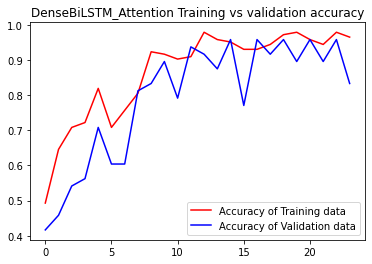

<Figure size 432x288 with 0 Axes>

In [334]:
get_acc = history1.history['accuracy']
value_acc = history1.history['val_accuracy']
get_loss = history1.history['loss']
validation_loss = history1.history['val_loss']

epochs = range(len(get_acc))
plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
plt.plot(epochs, value_acc, 'b', label='Accuracy of Validation data')
plt.title(f'{model_label} Training vs validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

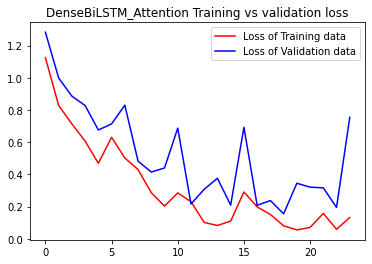

<Figure size 432x288 with 0 Axes>

In [335]:
epochs = range(len(get_loss))
plt.plot(epochs, get_loss, 'r', label='Loss of Training data')
plt.plot(epochs, validation_loss, 'b', label='Loss of Validation data')
plt.title(f'{model_label} Training vs validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

[Text(0, 0.5, 'blast'), Text(0, 1.5, 'blight'), Text(0, 2.5, 'tungro')]

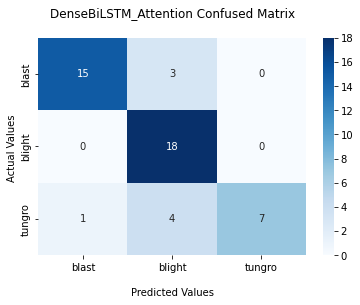

In [336]:
y_pred=model1.predict(testx)
pred=np.argmax(y_pred,axis=1)
ground = np.argmax(testy,axis=1)

conf_matrix = confusion_matrix(ground, pred)
ax = sb.heatmap(conf_matrix, annot=True, cmap='Blues')
ax.set_title(f'{model_label} Confused Matrix\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)

In [337]:
print(classification_report(ground,pred))

              precision    recall  f1-score   support

           0       0.94      0.83      0.88        18
           1       0.72      1.00      0.84        18
           2       1.00      0.58      0.74        12

    accuracy                           0.83        48
   macro avg       0.89      0.81      0.82        48
weighted avg       0.87      0.83      0.83        48



In [338]:
model1.evaluate(x=ImageDataGenerator().flow(testx, testy, batch_size=32), verbose = 1)

2/2 [==============================] - 0s 145ms/step - loss: 0.9462 - accuracy: 0.8333


[0.9461714625358582, 0.8333333134651184]

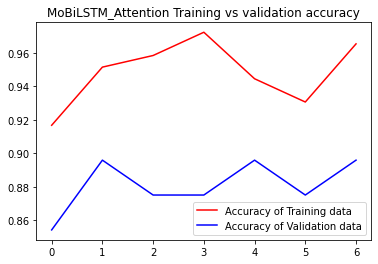

<Figure size 432x288 with 0 Axes>

In [339]:
get_acc = history2.history['accuracy']
value_acc = history2.history['val_accuracy']
get_loss = history2.history['loss']
validation_loss = history2.history['val_loss']

epochs = range(len(get_acc))
plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
plt.plot(epochs, value_acc, 'b', label='Accuracy of Validation data')
plt.title(f'{model_label2} Training vs validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

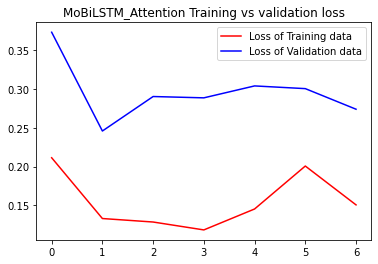

<Figure size 432x288 with 0 Axes>

In [340]:
epochs = range(len(get_loss))
plt.plot(epochs, get_loss, 'r', label='Loss of Training data')
plt.plot(epochs, validation_loss, 'b', label='Loss of Validation data')
plt.title(f'{model_label2} Training vs validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

[Text(0, 0.5, 'blast'), Text(0, 1.5, 'blight'), Text(0, 2.5, 'tungro')]

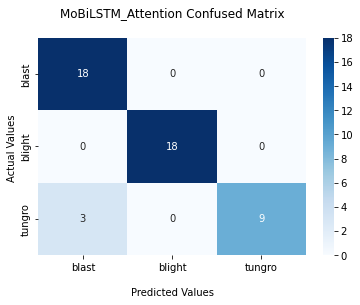

In [342]:
y_pred=model2.predict(testx)
pred=np.argmax(y_pred,axis=1)
ground = np.argmax(testy,axis=1)

conf_matrix = confusion_matrix(ground, pred)
ax = sb.heatmap(conf_matrix, annot=True, cmap='Blues')
ax.set_title(f'{model_label2} Confused Matrix\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)

In [350]:
print(classification_report(ground,pred))

              precision    recall  f1-score   support

           0       0.86      1.00      0.92        18
           1       1.00      1.00      1.00        18
           2       1.00      0.75      0.86        12

    accuracy                           0.94        48
   macro avg       0.95      0.92      0.93        48
weighted avg       0.95      0.94      0.94        48



In [343]:
model2.evaluate(x=ImageDataGenerator().flow(testx, testy, batch_size=32), verbose = 1)

2/2 [==============================] - 0s 44ms/step - loss: 0.1735 - accuracy: 0.9375


[0.1735318899154663, 0.9375]

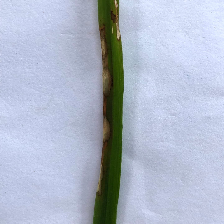

In [344]:
image = load_img(f"{dataset_dir}/blight/IMG_1034.jpg",target_size=(224,224))
image

In [345]:
image=img_to_array(image) 
image=image/255.0
prediction_image=np.array(image)
prediction_image= np.expand_dims(image, axis=0)

In [346]:
prediction=model1.predict(prediction_image)
value=np.argmax(prediction)
move_name=mapper(value)
#print(prediction)
#print(value)
print("Prediction is {}.".format(move_name))

Prediction is blight.


In [347]:
prediction=model2.predict(prediction_image)
value=np.argmax(prediction)
move_name=mapper(value)
#print(prediction)
#print(value)
print("Prediction is {}.".format(move_name))

Prediction is blight.
